In [2]:
import sys
sys.path.append(rf"/Users/baia/Desktop/PYTHON/mba_dsa_usp_esalq")

from TCC.utils.constantes import *
import matplotlib.pyplot as plt

## BTC Price, RVI_MA_10 e HV_10

- Price: mensura o valor de fechamento do BTC em determinado dia.
- RVI: Proxy de Momento e Sentimento (On-chain).
- HV: Proxy de Risco Imediato.

In [3]:
# df_btc_price = pd.read_csv(rf"/home/baia/z/git/data-science-analytics/TCC/data/dados_btc/raw/price_btc.csv")
df_btc_price = pd.read_csv(rf"raw/price_btc.csv")
df_btc_price['Data_UTC'] = pd.to_datetime(df_btc_price['time'], unit='s', utc=True,).dt.strftime("%Y-%m-%d")

In [4]:
print("BTC Price")
df_features = (
    df_btc_price
    # 1. Garante que temos as colunas base necessárias
    [['Data_UTC', 'open', 'high', 'low', 'close']]
    
    # 2. Calcula o RVI Bruto (Necessário antes da Média Móvel)
    # RVI = (Close - Open) / (High - Low)
    .assign(rvi_numerator = lambda df: df['close'] - df['open'])
    .assign(rvi_denominator = lambda df: df['high'] - df['low'])
    # O RVI clássico costuma suavizar num/den antes de dividir, mas para ML simples:
    .assign(RVI_raw = lambda df: df['rvi_numerator'] / df['rvi_denominator'])
    
    # 3. Calcula o RVI_MA_10
    .assign(RVI_MA_10 = lambda df: df['RVI_raw'].rolling(window=10).mean())

    # 4. Calcula o HV_10
    # Log Return -> Rolling Std (10 dias) -> Anualização (sqrt(365))
    .assign(log_ret = lambda df: np.log(df['close'] / df['close'].shift(1)))
    .assign(HV_10 = lambda df: df['log_ret'].rolling(window=10).std() * np.sqrt(365))

    # 5. Limpeza e Filtros
    .rename(columns={'close': 'btc_price'})
    .query(f"Data_UTC >= '{DATA_INICIO}' and Data_UTC <= '{DATA_FIM}'")

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))
    
    # 6. Seleção Final (Apenas o que vai para o modelo)
    [['Data_UTC', 'btc_price', 'RVI_MA_10', 'HV_10']]
)

df_base = df_features.copy()
df_base['Data_UTC'] = pd.to_datetime(df_features['Data_UTC'], unit='s', utc=True,).dt.strftime("%Y-%m-%d")


# Visualizar as primeiras linhas
df_features

BTC Price


,Data_UTC,btc_price,RVI_MA_10,HV_10
1454,2016-01-01 00:00:00+00:00,433.98,0.179806,0.660952
1455,2016-01-02 00:00:00+00:00,432.70,0.096933,0.651897
1456,2016-01-03 00:00:00+00:00,428.39,-0.021863,0.615216
1457,2016-01-04 00:00:00+00:00,432.90,0.030885,0.623172
1458,2016-01-05 00:00:00+00:00,431.84,0.090994,0.263608
...,...,...,...,...
4950,2025-07-28 00:00:00+00:00,118085.05,-0.003820,0.196846
4951,2025-07-29 00:00:00+00:00,117940.69,-0.002922,0.196949
4952,2025-07-30 00:00:00+00:00,117815.05,0.017956,0.194264
4953,2025-07-31 00:00:00+00:00,115760.52,-0.045459,0.222477


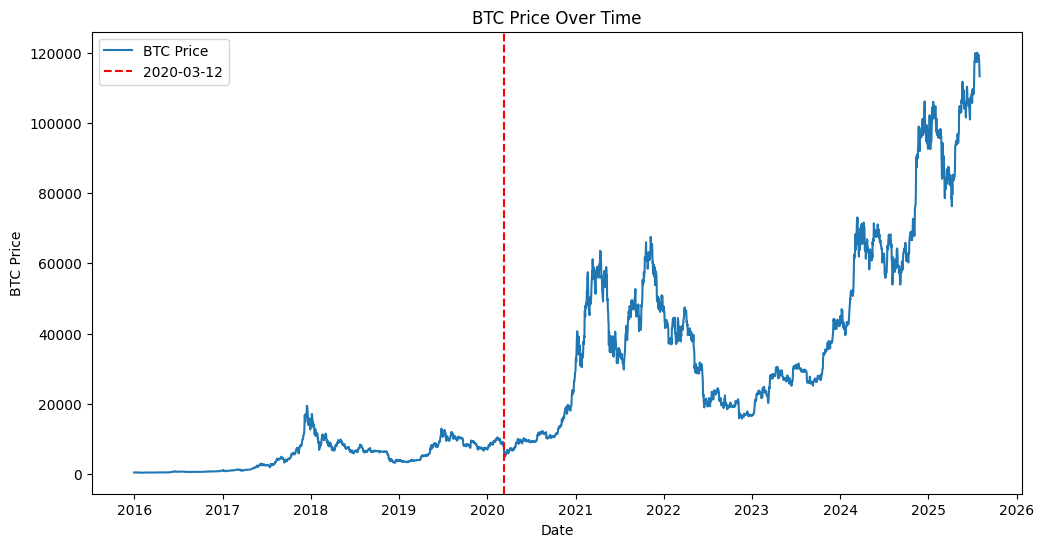

In [5]:
# Criando um grafico de series temporais sobre df_features
plt.figure(figsize=(12,6))
plt.plot(df_features['Data_UTC'], df_features['btc_price'], label='BTC Price')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='2020-03-12')
plt.title('BTC Price Over Time')
plt.legend()
plt.show()

## Funding Rate

- Dados de Funding Rate costumam ter muito ruído (oscilam a cada 8 horas). O ideal é trabalhar com uma média móvel para capturar a tendência do sentimento, e não o ruído momentâneo.

- a abordagem mais correta para transformar dados semanais em diários contínuos (suaves) é a Interpolação Linear.

- A lógica: Se o Funding era 0.01% na segunda-feira (Semana 1) e subiu para 0.08% na segunda-feira (Semana 2), assumimos que o sentimento foi esquentando gradualmente ao longo da semana, e não que explodiu de repente no último dia.

- start_date: 2016-05-12
- periodo: semanal

In [6]:
# df_funding_cexs = pd.read_csv(rf"/home/baia/git/data-science-analytics/TCC/data/dados_btc/raw/2016_funding_rate_cexs.csv")
df_funding_cexs = pd.read_csv(rf"raw/2016_funding_rate_cexs.csv")
df_funding_cexs['Data_UTC'] = pd.to_datetime(df_funding_cexs['Date'], utc=True,).dt.strftime("%Y-%m-%d")
df_funding_cexs['total_funding_rate_btc'] = df_funding_cexs[['BitMEX Funding Rate', 'Binance Funding Rate (USDT)','DyDx Exchange Funding Rates', 'Deribit Exchange Funding Rates']].mean(axis=1)

In [7]:
# 1. Definir o range completo de datas esperado para a pesquisa
# Isso garante que NENHUM dia fique de fora, mesmo que não exista no seu arquivo original
df_funding_fixed = (
    df_base[['Data_UTC']]

    .merge(
        df_funding_cexs[['Data_UTC', 'total_funding_rate_btc']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')
    
    # 3. Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares
    

    # 4. os primeiros dias continuarão NaN. Usamos bfill para preencher para trás o primeiro valor encontrado.
    .bfill()
    
    # # 5. Retorna ao formato original
    .reset_index()
)

df_funding_fixed

,Data_UTC,total_funding_rate_btc
0,2016-01-01 00:00:00+00:00,0.000511
1,2016-01-02 00:00:00+00:00,0.000511
2,2016-01-03 00:00:00+00:00,0.000511
3,2016-01-04 00:00:00+00:00,0.000511
4,2016-01-05 00:00:00+00:00,0.000511
...,...,...
3496,2025-07-28 00:00:00+00:00,0.000039
3497,2025-07-29 00:00:00+00:00,0.000034
3498,2025-07-30 00:00:00+00:00,0.000029
3499,2025-07-31 00:00:00+00:00,0.000023


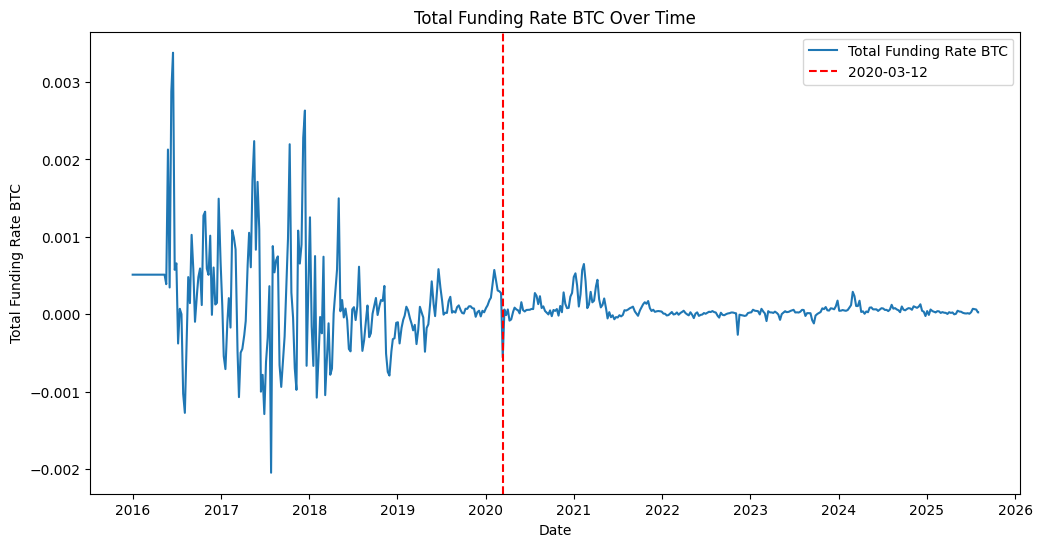

In [8]:
# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_funding_fixed['Data_UTC'], df_funding_fixed['total_funding_rate_btc'], label='Total Funding Rate BTC')
plt.xlabel('Date')
plt.ylabel('Total Funding Rate BTC')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='2020-03-12')
plt.title('Total Funding Rate BTC Over Time')
plt.legend()
plt.show()

## Supply held by miners

- a abordagem mais correta para transformar dados semanais em diários contínuos (suaves) é a Interpolação Linear.

- start_date: 2016-01-01
- periodo: semanal

In [9]:
df_supply_held_by = pd.read_csv(rf"raw/2011_supply_held_by.csv")
df_supply_held_by['Data_UTC'] = pd.to_datetime(df_supply_held_by['Date'], utc=True,).dt.strftime("%Y-%m-%d")

In [10]:
df_supply_held_miners = (df_base[['Data_UTC']]

    .merge(
        df_supply_held_by[['Data_UTC','Supply held by Miners']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')
    
    # 3. Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares

    # 4. os primeiros dias continuarão NaN. Usamos bfill para preencher para trás o primeiro valor encontrado.
    .bfill()
    
    # # 5. Retorna ao formato original
    .reset_index()

    .rename(columns={'Supply held by Miners': 'supply_held_by_miners_btc'})
        
)

df_supply_held_miners

,Data_UTC,supply_held_by_miners_btc
0,2016-01-01 00:00:00+00:00,2.317457e+06
1,2016-01-02 00:00:00+00:00,2.317457e+06
2,2016-01-03 00:00:00+00:00,2.317457e+06
3,2016-01-04 00:00:00+00:00,2.317457e+06
4,2016-01-05 00:00:00+00:00,2.317457e+06
...,...,...
3496,2025-07-28 00:00:00+00:00,1.702349e+06
3497,2025-07-29 00:00:00+00:00,1.702391e+06
3498,2025-07-30 00:00:00+00:00,1.702433e+06
3499,2025-07-31 00:00:00+00:00,1.702475e+06


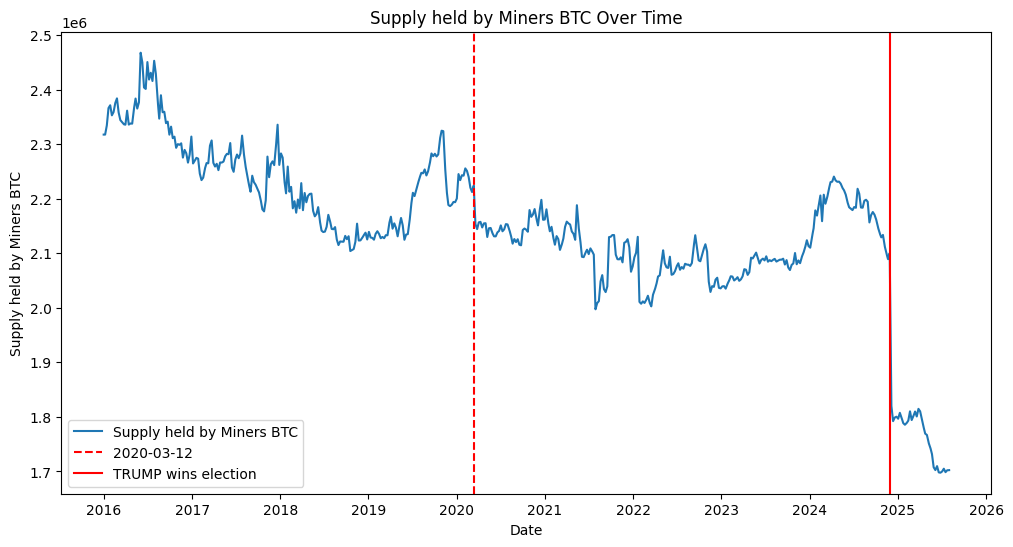

In [11]:
# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_supply_held_miners['Data_UTC'], df_supply_held_miners['supply_held_by_miners_btc'], label='Supply held by Miners BTC')
plt.xlabel('Date')
plt.ylabel('Supply held by Miners BTC')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='2020-03-12')
plt.axvline(pd.to_datetime('2024-11-30'), color='red', linestyle='-', label='TRUMP wins election')
plt.title('Supply held by Miners BTC Over Time')
plt.legend()
plt.show()

## Supply on Exchanges (as % of total supply) - Exchange_Inflow_Pressure

 - Aborda a relacao entre os BTC enviados a carteiras conhecidas de CEXs com as as wallets nao CEXs
- a abordagem mais correta para transformar dados semanais em diários contínuos (suaves) é a Interpolação Linear.

- start_date: 2011-01-01
- periodo: semanal

In [12]:
df_historical_balance = pd.read_csv(rf"raw/2011_inflow_outflow_balance_supply_cexs.csv")
# df_in_out_flow['Data_UTC'] = pd.to_datetime(df_in_out_flow['Date'], utc=True,).dt.strftime("%Y-%m-%d")
df_historical_balance['Data_UTC'] = pd.to_datetime(df_historical_balance['Date']).dt.strftime("%Y-%m-%d")
df_historical_balance[['Date',f'Supply on Exchanges (as % of total supply)']]

,Date,Supply on Exchanges (as % of total supply)
0,2009-01-08T00:00:00.000Z,0.000000
1,2009-01-15T00:00:00.000Z,0.000000
2,2009-01-22T00:00:00.000Z,0.000000
3,2009-01-29T00:00:00.000Z,0.000000
4,2009-02-05T00:00:00.000Z,0.000000
...,...,...
874,2025-10-09T00:00:00.000Z,6.006471
875,2025-10-16T00:00:00.000Z,6.069361
876,2025-10-23T00:00:00.000Z,6.046480
877,2025-10-30T00:00:00.000Z,6.088085


In [13]:
df_historical_balance_processed = (df_base[['Data_UTC']]

    .merge(df_historical_balance[['Data_UTC','Supply on Exchanges (as % of total supply)']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')
    
    .rename(columns={'Supply on Exchanges (as % of total supply)': 'exchange_supply_pct'})

    # Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares
    
    )

df_historical_balance_processed

,exchange_supply_pct
Data_UTC,
2016-01-01 00:00:00+00:00,NaN
2016-01-02 00:00:00+00:00,NaN
2016-01-03 00:00:00+00:00,NaN
2016-01-04 00:00:00+00:00,NaN
2016-01-05 00:00:00+00:00,NaN
...,...
2025-07-28 00:00:00+00:00,6.155575
2025-07-29 00:00:00+00:00,6.155355
2025-07-30 00:00:00+00:00,6.155134


In [14]:
df_exchange_processed = (df_historical_balance_processed

    #  os primeiros dias continuarão NaN. Usamos bfill para preencher para trás o primeiro valor encontrado.
    .bfill()
    
    # #  Retorna ao formato original
    .reset_index()

    # 1. Capturar o Fluxo (O ato de enviar)
    # Se positivo: Estão enviando (Pressão de Venda)
    # Se negativo: Estão sacando (Acumulação)
    .assign(Net_Flow_Pct = lambda df: df['exchange_supply_pct'].diff())

    # 2. Capturar o "Choque" (O pico de 20x)
    # Z-Score móvel: Mede quantos desvios padrões o fluxo de hoje está acima da média dos últimos 30 dias.
    # Isso ajuda o modelo a identificar quando o envio é "anormal" (ex: panic selling).
    .assign(Flow_Z_Score = lambda df: 
            (df['Net_Flow_Pct'] - df['Net_Flow_Pct'].rolling(30).mean()) / 
            df['Net_Flow_Pct'].rolling(30).std()
    )
    
    # Seleção das features finais
    # A 'Net_Flow_Pct' mostra a direção.
    # A 'Flow_Z_Score' mostra a intensidade.
    [['Data_UTC', 'Net_Flow_Pct', 'Flow_Z_Score']]
)

df_exchange_processed

,Data_UTC,Net_Flow_Pct,Flow_Z_Score
0,2016-01-01 00:00:00+00:00,NaN,NaN
1,2016-01-02 00:00:00+00:00,0.00000,NaN
2,2016-01-03 00:00:00+00:00,0.00000,NaN
3,2016-01-04 00:00:00+00:00,0.00000,NaN
4,2016-01-05 00:00:00+00:00,0.00000,NaN
...,...,...,...
3496,2025-07-28 00:00:00+00:00,-0.00022,-0.187774
3497,2025-07-29 00:00:00+00:00,-0.00022,-0.181735
3498,2025-07-30 00:00:00+00:00,-0.00022,-0.175709
3499,2025-07-31 00:00:00+00:00,-0.00022,-0.169696


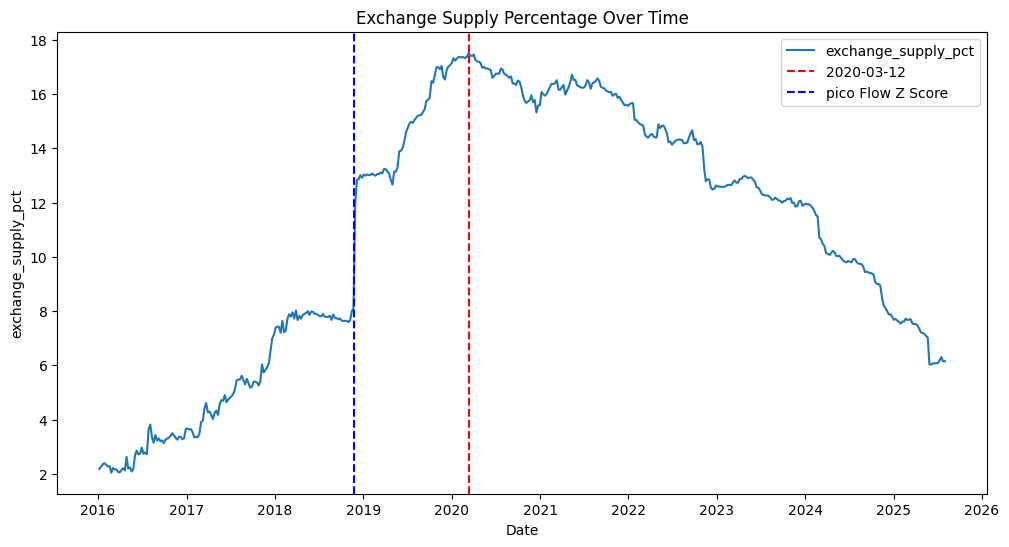

In [15]:
df_historical_balance_chart = df_historical_balance_processed.reset_index()
df_historical_balance_chart

# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_historical_balance_chart['Data_UTC'], df_historical_balance_chart['exchange_supply_pct'], label='exchange_supply_pct')
plt.xlabel('Date')
plt.ylabel('exchange_supply_pct')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='2020-03-12')
plt.axvline(pd.to_datetime('2018-11-23'), color='blue', linestyle='--', label='pico Flow Z Score')
plt.title('Exchange Supply Percentage Over Time')
plt.legend()
plt.show()

## BTC and S&P 500 Price Divergence

- Mede o afastamento relativo entre o preço do Bitcoin e o índice S&P 500.
- a abordagem mais correta para transformar dados semanais em diários contínuos (suaves) é a Interpolação Linear.

- start_date: 2010-07-05
- periodo: semanal

In [16]:
df_historical_balance = pd.read_csv(rf"raw/2011_btcS&P500_divergence_rsi_volatilly.csv")
# df_in_out_flow['Data_UTC'] = pd.to_datetime(df_in_out_flow['Date'], utc=True,).dt.strftime("%Y-%m-%d")
df_historical_balance['Data_UTC'] = pd.to_datetime(df_historical_balance['Date']).dt.strftime("%Y-%m-%d")
df_historical_balance[['Data_UTC', 'BTC and S&P 500 Price Divergence']]

,Data_UTC,BTC and S&P 500 Price Divergence
0,2010-07-15,0.174229
1,2010-07-17,0.174229
2,2010-07-18,0.174229
3,2010-07-19,0.174229
4,2010-07-20,0.174229
...,...,...
5591,2025-11-05,0.124827
5592,2025-11-06,0.148850
5593,2025-11-07,0.148850
5594,2025-11-08,0.148850


In [17]:
df_sp500_btc_divergence = (df_base[['Data_UTC']]

    .merge(df_historical_balance[['Data_UTC', 'BTC and S&P 500 Price Divergence']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')
    
    .rename(columns={'BTC and S&P 500 Price Divergence': 'btc_sp500_price_divergence'})

    # Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares

    # --- Tratamento 1: Divergência S&P 500 ---
    # Séries de divergência de preço costumam não ser estacionárias (têm tendência).
    # Usamos a variação (diff) para saber se o BTC está se "descolando" HOJE.
    .assign(SPX_Divergence_Diff = lambda df: df['btc_sp500_price_divergence'].diff())

    .reset_index()
    
    )

df_sp500_btc_divergence

,Data_UTC,btc_sp500_price_divergence,SPX_Divergence_Diff
0,2016-01-01 00:00:00+00:00,0.325989,NaN
1,2016-01-02 00:00:00+00:00,0.325989,0.000000
2,2016-01-03 00:00:00+00:00,0.325989,0.000000
3,2016-01-04 00:00:00+00:00,0.325989,0.000000
4,2016-01-05 00:00:00+00:00,0.325989,0.000000
...,...,...,...
3496,2025-07-28 00:00:00+00:00,-0.047644,0.000000
3497,2025-07-29 00:00:00+00:00,-0.047644,0.000000
3498,2025-07-30 00:00:00+00:00,-0.047644,0.000000
3499,2025-07-31 00:00:00+00:00,-0.026757,0.020887


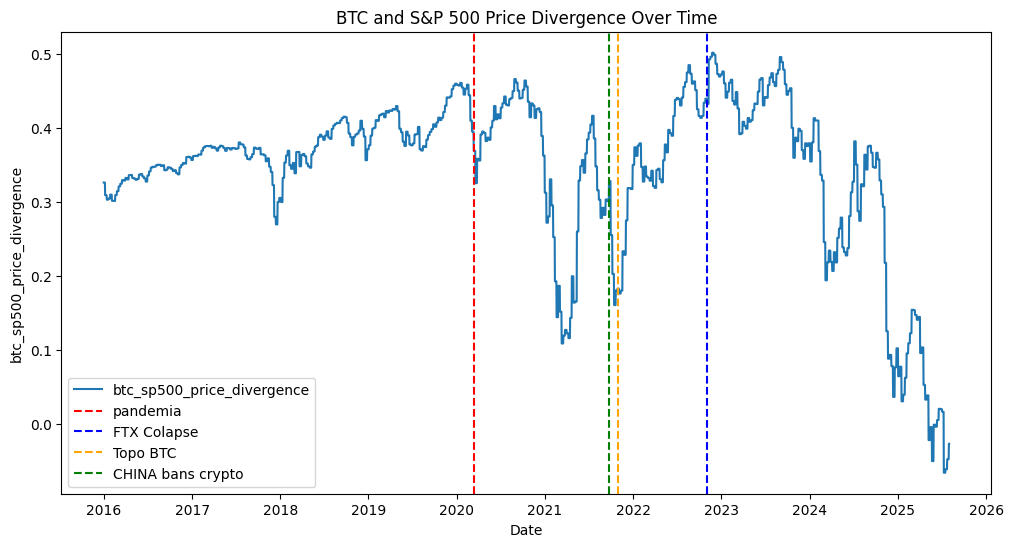

In [18]:
# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_sp500_btc_divergence['Data_UTC'], df_sp500_btc_divergence['btc_sp500_price_divergence'], label='btc_sp500_price_divergence')
plt.xlabel('Date')
plt.ylabel('btc_sp500_price_divergence')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='pandemia')
plt.axvline(pd.to_datetime('2022-11-01'), color='blue', linestyle='--', label='FTX Colapse')
plt.axvline(pd.to_datetime('2021-11-01'), color='orange', linestyle='--', label='Topo BTC')
plt.axvline(pd.to_datetime('2021-09-24'), color='green', linestyle='--', label='CHINA bans crypto')
plt.title('BTC and S&P 500 Price Divergence Over Time')
plt.legend()
plt.show()

## Coinbase premium Index

- Diferença entre o preço do Bitcoin na Coinbase Pro (Par BTC/USD) e na Binance (Par BTC/USDT). 
- Indica se o varejo tem mais interesse do que o institucional no bitcoine  vice versa
- a abordagem mais correta para transformar dados semanais em diários contínuos (suaves) é a Interpolação Linear.

- start_date: 20108-04-18
- periodo: Diario

In [19]:
df_coinbase_premium = pd.read_csv(rf"raw/2018_coinbase_premium_index.csv")
# df_in_out_flow['Data_UTC'] = pd.to_datetime(df_in_out_flow['Date'], utc=True,).dt.strftime("%Y-%m-%d")
df_coinbase_premium['Data_UTC'] = pd.to_datetime(df_coinbase_premium['time'], utc=True).dt.strftime("%Y-%m-%d")
df_coinbase_premium[['Data_UTC', 'close']]

,Data_UTC,close
0,2018-04-14,4.10
1,2018-04-15,0.25
2,2018-04-16,-15.99
3,2018-04-17,7.08
4,2018-04-18,-20.95
...,...,...
2803,2025-12-16,-9.41
2804,2025-12-17,-33.45
2805,2025-12-18,-56.39
2806,2025-12-19,-44.29


In [20]:
df_coinbase_premium_dif = (df_base[['Data_UTC']]

    .merge(df_coinbase_premium[['Data_UTC', 'close']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')
    
    .rename(columns={'close': 'coinbase_premium_index_close_price'})

    # Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares

    # --- Tratamento 1: Divergência S&P 500 ---
    # Séries de divergência de preço costumam não ser estacionárias (têm tendência).
    # Usamos a variação (diff) para saber se o BTC está se "descolando" HOJE.
    .assign(coinbase_premium_Diff = lambda df: df['coinbase_premium_index_close_price'].diff())

    .reset_index()
    
    )

df_coinbase_premium_dif

,Data_UTC,coinbase_premium_index_close_price,coinbase_premium_Diff
0,2016-01-01 00:00:00+00:00,NaN,NaN
1,2016-01-02 00:00:00+00:00,NaN,NaN
2,2016-01-03 00:00:00+00:00,NaN,NaN
3,2016-01-04 00:00:00+00:00,NaN,NaN
4,2016-01-05 00:00:00+00:00,NaN,NaN
...,...,...,...
3496,2025-07-28 00:00:00+00:00,8.27,-41.70
3497,2025-07-29 00:00:00+00:00,-17.37,-25.64
3498,2025-07-30 00:00:00+00:00,-10.15,7.22
3499,2025-07-31 00:00:00+00:00,-2.95,7.20


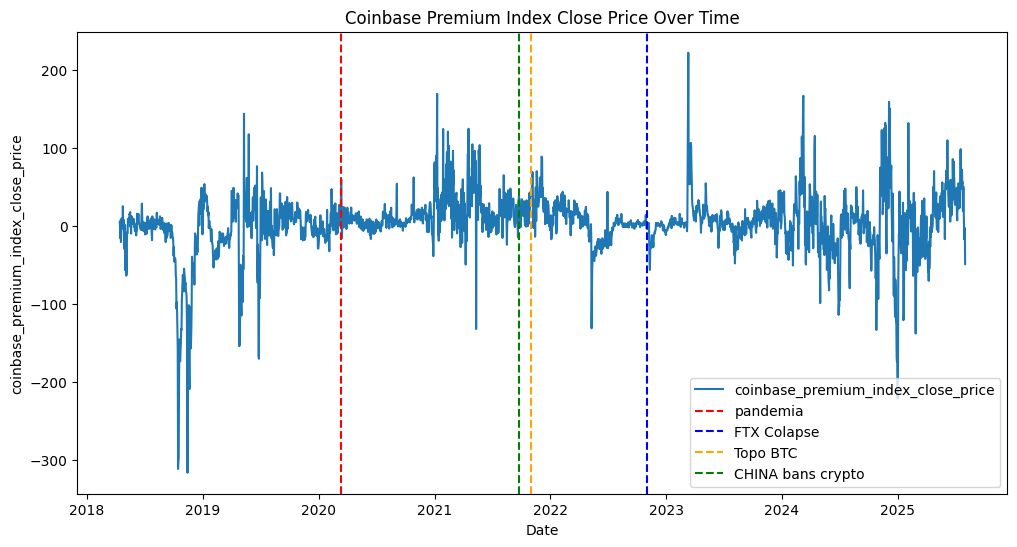

In [21]:
# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_coinbase_premium_dif['Data_UTC'], df_coinbase_premium_dif['coinbase_premium_index_close_price'], label='coinbase_premium_index_close_price')
plt.xlabel('Date')
plt.ylabel('coinbase_premium_index_close_price')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='pandemia')
plt.axvline(pd.to_datetime('2022-11-01'), color='blue', linestyle='--', label='FTX Colapse')
plt.axvline(pd.to_datetime('2021-11-01'), color='orange', linestyle='--', label='Topo BTC')
plt.axvline(pd.to_datetime('2021-09-24'), color='green', linestyle='--', label='CHINA bans crypto')
plt.title('Coinbase Premium Index Close Price Over Time')
plt.legend()
plt.show()

## MVRV Z-score

- O indicador nasce da comparação entre duas formas diferentes de valorar o Bitcoin:

- Market Value (MV) - Valor de Mercado
- É o preço atual multiplicado pela quantidade total de moedas em circulação.
- Significado: É o preço da "vitrine". Representa o sentimento momentâneo e a especulação atual.

- Realized Value (RV) - Valor RealizadoEsta é a métrica revolucionária do on-chain. Em vez de multiplicar todas as moedas pelo preço atual, ela multiplica cada moeda pelo preço do dia em que ela foi movimentada pela última vez.
- Significado: É o "preço de custo" médio de todos os participantes do mercado. Remove as moedas perdidas e o peso da especulação momentânea. É considerado o "Valor Justo" (Fair Value) orgânico da rede.
- Exemplo: Se você comprou 1 BTC a $10.000 em 2020 e nunca mais mexeu, para o Realized Cap esse BTC vale $10.000, mesmo que o preço de tela hoje seja $100.000.

- MVRV = 1: O preço de mercado é igual ao preço de custo médio (Ninguém tem lucro não realizado). Fundo de mercado.
- MVRV = 3: O preço de mercado é 3x maior que o custo médio. Investidores têm 200% de lucro não realizado (Incentivo alto para vender).

- start_date: 2017-01-02
- periodo: Diario

In [22]:
df_mvrv = pd.read_csv(rf"raw/2017_mvrv_z_score.csv")
# df_in_out_flow['Data_UTC'] = pd.to_datetime(df_in_out_flow['Date'], utc=True,).dt.strftime("%Y-%m-%d")
df_mvrv['Data_UTC'] = pd.to_datetime(df_mvrv['time'], utc=True).dt.strftime("%Y-%m-%d")
df_mvrv[['Data_UTC', 'Plot']].query("Plot.isna() == False")

,Data_UTC,Plot
729,2017-01-02,35.904489
730,2017-01-03,36.302448
731,2017-01-04,40.750753
732,2017-01-05,34.060526
733,2017-01-06,28.462213
...,...,...
3999,2025-12-16,19.417985
4000,2025-12-17,18.764134
4001,2025-12-18,18.468886
4002,2025-12-19,19.636943


In [23]:
df_mvrv_zscore = (df_base[['Data_UTC']]

    .merge(df_mvrv[['Data_UTC', 'Plot']], how='left', on='Data_UTC')

    .assign(Data_UTC = lambda df: pd.to_datetime(df['Data_UTC'], utc=True))

    # 2. Prepara para Interpolacao: Define a data como índice
    .set_index('Data_UTC')

    .rename(columns={'Plot': 'mvrv_zscore_close_price'})

    # Interpolacao Linear
    # Conecta os pontos semanais com uma linha reta para preencher os dias vazios.
    # Ex: Se seg=0.1 e próxima seg=0.8, quarta-feira será aprox 0.33.
    .interpolate(method='time') # 'time' é mais preciso que 'linear' se houver buracos irregulares

    # --- Tratamento 1: Divergência S&P 500 ---
    # Séries de divergência de preço costumam não ser estacionárias (têm tendência).
    # Usamos a variação (diff) para saber se o BTC está se "descolando" HOJE.
    .assign(mvrv_zscore_close_price_diff = lambda df: df['mvrv_zscore_close_price'].diff())

    .reset_index()

    .query("mvrv_zscore_close_price.isna() == False")

    )

df_mvrv_zscore

,Data_UTC,mvrv_zscore_close_price,mvrv_zscore_close_price_diff
367,2017-01-02 00:00:00+00:00,35.904489,NaN
368,2017-01-03 00:00:00+00:00,36.302448,0.397958
369,2017-01-04 00:00:00+00:00,40.750753,4.448306
370,2017-01-05 00:00:00+00:00,34.060526,-6.690227
371,2017-01-06 00:00:00+00:00,28.462213,-5.598313
...,...,...,...
3496,2025-07-28 00:00:00+00:00,31.205929,-0.569643
3497,2025-07-29 00:00:00+00:00,31.104918,-0.101011
3498,2025-07-30 00:00:00+00:00,31.014336,-0.090582
3499,2025-07-31 00:00:00+00:00,30.201268,-0.813068


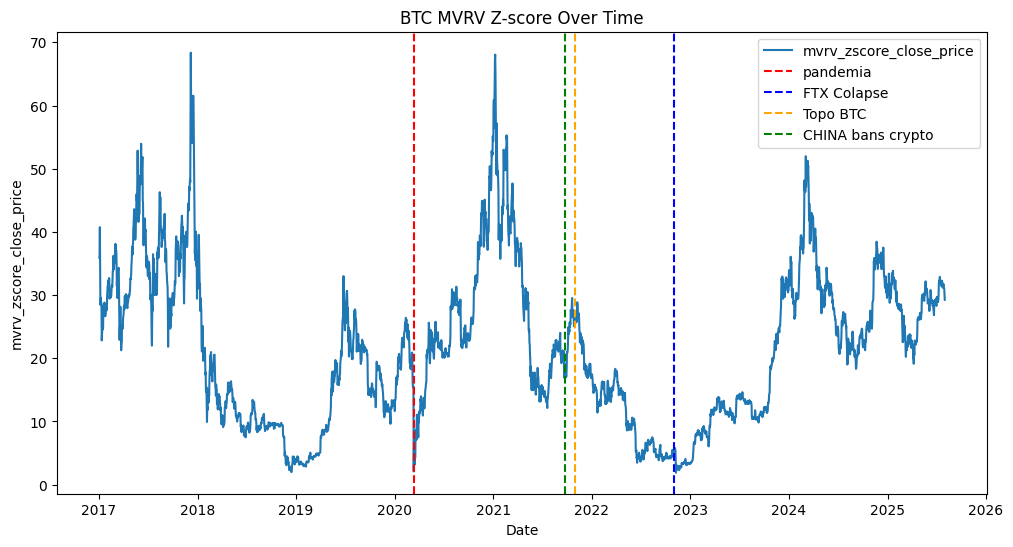

In [24]:
# criando um grafico de series temporais
plt.figure(figsize=(12,6))
plt.plot(df_mvrv_zscore['Data_UTC'], df_mvrv_zscore['mvrv_zscore_close_price'], label='mvrv_zscore_close_price')
plt.xlabel('Date')
plt.ylabel('mvrv_zscore_close_price')
plt.axvline(pd.to_datetime('2020-03-12'), color='red', linestyle='--', label='pandemia')
plt.axvline(pd.to_datetime('2022-11-01'), color='blue', linestyle='--', label='FTX Colapse')
plt.axvline(pd.to_datetime('2021-11-01'), color='orange', linestyle='--', label='Topo BTC')
plt.axvline(pd.to_datetime('2021-09-24'), color='green', linestyle='--', label='CHINA bans crypto')
plt.title('BTC MVRV Z-score Over Time')
plt.legend()
plt.show()